Consider a 3-body-region configuration. Let the inner two regions be well-proportioned. Compute the number of terms needed for each of the 4 regions to converge. Run this for each of the 3 regions heaving. Vary the 5 dependencies linked to the outermost region, and see how this affects each convergence.

In [77]:
import sys
import os
sys.path.append(os.path.relpath('../../../'))
sys.path.append(os.path.relpath('../../'))

from helpers import *
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [105]:
class ConvergenceProblemNeighbors(ConvergenceProblemI):
  def get_all_heaves(self):
    heaves = []
    for i in range(self.boundary_count):
      heave = [1 if i == j else 0 for j in range(self.boundary_count)]
      heaves.append(heave)
    return heaves
  
  def e_varied_matrices(self, full_a_matrix, nmk_max):
    big_nmk = self.NMK[-1]
    all_a_matrices = []
    for i in range(1, nmk_max + 1):
      a_matrix = full_a_matrix[: (self.size - big_nmk + i), : (self.size - big_nmk + i)]
      all_a_matrices.append(a_matrix)
    return all_a_matrices

  def e_varied_b_vectors(self, full_b_vector, nmk_max):
    big_nmk = self.NMK[-1]
    all_b_vectors = []
    for i in range(1, nmk_max + 1):
      b_vector = full_b_vector[: (self.size - big_nmk + i)]
      all_b_vectors.append(b_vector)
    return all_b_vectors
    
  def full_convergence_study(self, nmk_max, m0s, mks):
    # Do study convergence across all regions, for all distinct heaves
    heaves = self.get_all_heaves()
    full_a_matrix = self.a_matrix()
    full_bs_across_heaves = []
    full_cs_across_heaves = []
    all_cs_across_heaves = []
    for heave_vector in heaves:
      self.heaving = heave_vector
      full_bs_across_heaves.append(self.b_vector())
      full_c_vector = self.c_vector()
      full_cs_across_heaves.append(full_c_vector)
      all_cs_across_regions = []
      for region in range(self.boundary_count):
        all_cs_across_regions.append(self.get_c_vectors(full_c_vector, nmk_max, region))
      all_cs_across_regions.append([full_c_vector for i in range(nmk_max)]) # for the e region
      all_cs_across_heaves.append(all_cs_across_regions)
    output = {}

    for idx, m0 in enumerate(m0s):
      out_for_m0 = {}
      self.change_m0_mk(m0, mks[idx])
      omega = self.angular_freq(self.m0)

      full_a_matrix = self.a_matrix_from_old(full_a_matrix) # match the m0
      all_a_matrices_across_regions = [self.get_sub_matrices(full_a_matrix, nmk_max, region) for region in range(self.boundary_count)]
      all_a_matrices_across_regions.append(self.e_varied_matrices(full_a_matrix, nmk_max))

      for heaving_region, heave_vector in enumerate(heaves):
        self.heaving = heave_vector
        full_b_vector = self.b_vector_from_old(full_bs_across_heaves[heaving_region]) # match the m0
        full_c_vector = full_cs_across_heaves[heaving_region]
        particular_contribution = self.int_phi_p_i(heaving_region)
        out_for_heave = {}
        for region in range(self.boundary_count + 1):
          print(region)
          if region == self.boundary_count:
            all_b_vectors = self.e_varied_b_vectors(full_b_vector, nmk_max)
          else:
            all_b_vectors = self.get_b_vectors(full_b_vector, nmk_max, region)
          all_c_vectors = all_cs_across_heaves[heaving_region][region]
          am_lst, dp_lst = [], []
          for nmk in range(1, nmk_max + 1):
            x = self.get_unknown_coeffs(all_a_matrices_across_regions[region][nmk - 1], all_b_vectors[nmk - 1])
            sub_x = x[:-nmk] if region == self.boundary_count else x[:-self.NMK[-1]]
            raw_hydro = 2 * np.pi * (np.dot(all_c_vectors[nmk - 1], sub_x) + particular_contribution)
            # follow the capytaine convention
            am_lst.append(raw_hydro.real * self.rho) # added mass
            dp_lst.append(raw_hydro.imag * omega * self.rho) # damping
          out_for_region = {"ams" : am_lst,
                            "dps" : dp_lst}
          out_for_heave[region] = out_for_region
        x = self.get_unknown_coeffs(full_a_matrix, full_b_vector)
        am, dp = self.hydro_coeffs(x, "capytaine")
        out_for_heave["am"], out_for_heave["dp"] = am, dp
        out_for_m0[heaving_region] = out_for_heave
      output[m0] = out_for_m0
    return output

In [134]:
def swap_vals(prob, d, a):
  # Avoids mk recomputations.
  prob.d = d
  prob.a = a
  prob.scale = a
  return prob

def generate_convergence_data(data, error_lst): # shadows the one in helpers.py for this notebook's data structure
  hydro_keys = ["am", "dp"]
  for data_dict in data:
    region_count = len(data_dict["a"]) + 1
    for m0 in data_dict["m0s"]:
      for heaving_region in range(region_count - 1):
        for region in range(region_count):
          dummy_dict = {"am" : data_dict[m0][heaving_region]["am"],
                        "dp" : data_dict[m0][heaving_region]["dp"],
                        "ams" : data_dict[m0][heaving_region][region]["ams"],
                        "dps" : data_dict[m0][heaving_region][region]["dps"]}
          for hydro in hydro_keys:
              for error in error_lst:
                data_dict[m0][heaving_region][region][f"convergence point {error:.2g} " + hydro] = convergence_point(dummy_dict, hydro, error)

def populate_predet_d_a(m0h, hmdr, left_ratio, right_ratio,
                        hmd0, hmd1, radwidth0, radwidth1):
  hmd2 = hmd1/left_ratio
  h = hmd2 * right_ratio
  m0 = m0h/h
  radwidth2 = hmd2/hmdr

  hmds = [hmd0, hmd1, hmd2]
  radwidths = [radwidth0, radwidth1, radwidth2]
  d = [h - hmds[i] for i in range(3)]
  a = [sum(radwidths[:i + 1]) for i in range(3)]
  for i in range(3):
     assert radwidths[i] > 0
     assert d[i] > 0
  
  return h, m0, d, a

def solve_and_store(h, m0s, mks, prob, nmk_max, d, a):
  info = {"h" : h,
          "d" : d,
          "a" : a,
          "m0s" : m0s}
  print(info)
  swap_vals(prob, d, a)
  data_dict = merge_dicts(info, prob.full_convergence_study(nmk_max, m0s, mks))
  return data_dict

For best results, keep as much as possible about the inner regions fixed while varying other components.

1. Keep all (h-d) and radwidths the same, but vary m0 * h. Vary m0 to check m0h, fix m0h and vary h to investigate h/(h-d). Since these dependencies seem to dominate for damping, important to check.
2. Fix everything except the outermost radial width. This varies (h-d)/radwidth and radwidth/a2.
3. Vary (h-d1)/(h-d2). This necessarily changes things for the middle region, but still gives good results for the e-region. This can be done in a grid with the radwidth variation.

If we want to keep the inner two regions completely fixed, this fixes 4 variables out of 8, but theorizing 5 dependencies, effects will invariably be coupled. But this is still a good starting point.

In [109]:
file1 = "predetermined_1.pkl"
file2 = "predetermined_2.pkl"

big_nmk = 200
nmk_max = 150
NMK = [big_nmk] * 4
rho = 1023

# all_prob_dicts = []
# h, d, a = 6, [3, 2, 1], [1, 2, 3]
# m0 = 1
# prob = ConvergenceProblemNeighbors(h, d, a, [0, 0, 1], NMK, m0, rho)
# mk = prob.m_k
# all_prob_dicts.append(solve_and_store(h, m0, mk, prob, nmk_max, d, a))
# update_data_file(all_prob_dicts, file1)


# prob_dict_sets = [[], [], []]
prob_dict_sets = open_pkl_file(file2)
hmd0, hmd1, radwidth0, radwidth1 = 2, 3, 1, 1

# # Vary m0 * h without varying h (i.e. vary m0).
left_ratio, right_ratio, hmdr = 0.8, 1.3, 10
m0hs = list(np.linspace(1, 5, 5)) + list(np.linspace(10, 40, 7))
h, m0, d, a = populate_predet_d_a(m0hs[0], hmdr, left_ratio, right_ratio,
                               hmd0, hmd1, radwidth0, radwidth1)
m0s = []
mks = []
prob = ConvergenceProblemNeighbors(h, d, a, [0, 0, 1], NMK, m0, rho)
for m0h in m0hs:
  h, m0, d, a = populate_predet_d_a(m0h, hmdr, left_ratio, right_ratio,
                                    hmd0, hmd1, radwidth0, radwidth1)
  prob.change_m0(m0)
  m0s.append(m0)
  mks.append(prob.m_k)
prob_dict_sets[0].append(solve_and_store(h, m0s, mks, prob, nmk_max, d, a))
update_data_file(prob_dict_sets, file2)

# # Vary h (for the h/(h-d) ratio) without varying m0h.
# m0h, left_ratio, hmdr = 10, 0.8, 10
# right_ratios = list(np.linspace(1.1, 2, 10)) + list(np.linspace(2, 10, 17))
# prob_dict_set2 = []
# for right_ratio in right_ratios:
#   h, m0, d, a = populate_predet_d_a(m0h, hmdr, left_ratio, right_ratio,
#                                     hmd0, hmd1, radwidth0, radwidth1)
#   prob = ConvergenceProblemNeighbors(h, d, a, [0, 0, 1], NMK, m0, rho)
#   mk = prob.m_k
#   prob_dict_sets[1].append(solve_and_store(h, [m0], [mk], prob, nmk_max, d, a))
# update_data_file(prob_dict_sets, file2)

# Vary (h-d2)/radwidth and (h-d1)/(h-d2) by varying (h-d2) and radwidth.
# For constant radwidths for constant ((h-d2)/radwidth)/left_ratio)
# (h-d2)/radwidth must be > 1
# m0h, right_ratio = 10, 1.3
# hmdrs = list(np.linspace(2, 20, 10))
# left_ratios = (list(0.8 * np.linspace(0.5, 0.9, 5)) +
#                list(0.8 * np.linspace(0.95, 1.05, 11)) +
#                list(0.8 * np.linspace(1.1, 1.2, 2)))
# for left_ratio in left_ratios:
#   h, m0, d, a = populate_predet_d_a(m0h, hmdrs[0], left_ratio, right_ratio,
#                                     hmd0, hmd1, radwidth0, radwidth1)
#   prob = ConvergenceProblemNeighbors(h, d, a, [0, 0, 1], NMK, m0, rho)
#   mk = prob.m_k
#   for hmdr in hmdrs:
#     h, m0, d, a = populate_predet_d_a(m0h, hmdr, left_ratio, right_ratio,
#                                       hmd0, hmd1, radwidth0, radwidth1) # modifies d and a but not m0 and h
#     prob_dict_sets[2].append(solve_and_store(h, [m0], [mk], prob, nmk_max, d, a))
#   update_data_file(prob_dict_sets, file2)

# h, d, a = 6, [3, 2, 1], [1, 2, 3]
# m0 = 1
# prob = ConvergenceProblemNeighbors(h, d, a, [0, 0, 1], NMK, m0, rho)
# mk = prob.m_k
# all_prob_dicts.append(solve_and_store(h, m0, mk, prob, nmk_max, d, a))
# update_data_file(all_prob_dicts, file1)

{'h': 4.875, 'd': [2.875, 1.875, 1.125], 'a': [1, 2, 2.375], 'm0s': [np.float64(0.20512820512820512), np.float64(0.41025641025641024), np.float64(0.6153846153846154), np.float64(0.8205128205128205), np.float64(1.0256410256410255), np.float64(2.051282051282051), np.float64(3.076923076923077), np.float64(4.102564102564102), np.float64(5.128205128205129), np.float64(6.153846153846154), np.float64(7.17948717948718), np.float64(8.205128205128204)]}
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


In [135]:
# all_prob_dicts = open_pkl_file(file1)
# generate_convergence_data(all_prob_dicts, [0.01, 0.005])

prob_dict_sets = open_pkl_file(file2)
for prob_dict_set in prob_dict_sets:
  generate_convergence_data(prob_dict_set, [0.01, 0.005])

In [137]:
def plot_by_heaves_and_regions(config, error, hydro, m0 = None):
  heaving_regions, regions = len(config[0]["d"]), len(config[0]["d"]) + 1 
  if m0 is None:
    m0 = config[0]["m0s"][0]
  xs, ys, zs = [], [], []
  for prob in config:
    for heaving_region in range(heaving_regions):
      for region in range(regions):
        xs.append(region)
        ys.append(heaving_region)
        zs.append(prob[m0][heaving_region][region][f"convergence point {error:.2g} " + hydro])
  data = np.column_stack((xs, zs, ys))
  plot_3tuples_2d(data, xlabel = "Converging region", ylabel = "Heaving region",
                  clabel = f"convergence point {error:.2g}", title = hydro)
  
def nmk_hypothesis_1(prob, error, heaving_region, m0 = None):
  regions = len(prob["d"]) + 1
  if m0 is None:
    m0 = prob["m0s"][0]
  NMK = []
  for region in range(regions):
    NMK.append(max([prob[m0][heaving_region][region][f"convergence point {error:.2g} am"],
                    prob[m0][heaving_region][region][f"convergence point {error:.2g} dp"]]))
  return NMK

def nmk_hypothesis_2(prob, error, m0 = None):
  heaving_regions, regions = len(prob["d"]), len(prob["d"]) + 1
  NMKs = [nmk_hypothesis_1(prob, error, heaving_region, m0) for heaving_region in range(heaving_regions)]
  NMK = [max([NMKs[heaving_region][region] for heaving_region in range(heaving_regions)]) for region in range(regions)]
  return NMK

# Note that influenced hydros will probably need hypothesis 2.

In [51]:
NMKs1 = [nmk_hypothesis_1(all_prob_dicts[0], 0.01, heave) for heave in range(3)]
NMK2 = nmk_hypothesis_2(all_prob_dicts[0], 0.01)
print(NMKs1, NMK2)

[[14, 20, 16, 24], [2, 14, 19, 23], [1, 3, 31, 37]] [14, 20, 31, 37]


In [52]:
for i in range(3):
  print(all_prob_dicts[0][m0][i]["am"], all_prob_dicts[0][m0][i]["dp"])
  heaving = [0 if i != j else 1 for j in range(3)]
  prob = ConvergenceProblemNeighbors(h, d, a, heaving, NMKs1[i], m0, rho)
  print(prob.hydro_coeffs(prob.get_unknown_coeffs(prob.a_matrix(), prob.b_vector()), "capytaine"))
  prob = ConvergenceProblemNeighbors(h, d, a, heaving, NMK2, m0, rho)
  print(prob.hydro_coeffs(prob.get_unknown_coeffs(prob.a_matrix(), prob.b_vector()), "capytaine"))

2110.4602645032483 22.909032390473833
(np.float64(2121.9972571484377), np.float64(22.707184137801466))
(np.float64(2122.2994197422995), np.float64(22.82158062659639))
8757.655385246337 403.6671614621701
(np.float64(8837.767478159913), np.float64(402.26171624313696))
(np.float64(8790.385087592193), np.float64(402.031614499556))
12537.608508004827 4128.072588550344
(np.float64(12605.587402054132), np.float64(4153.493426865103))
(np.float64(12554.476678888981), np.float64(4117.336017821891))


2110.4602645032483
22.909032390473833


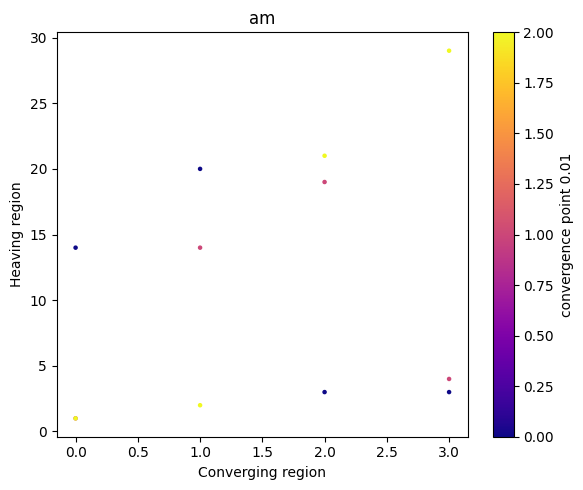

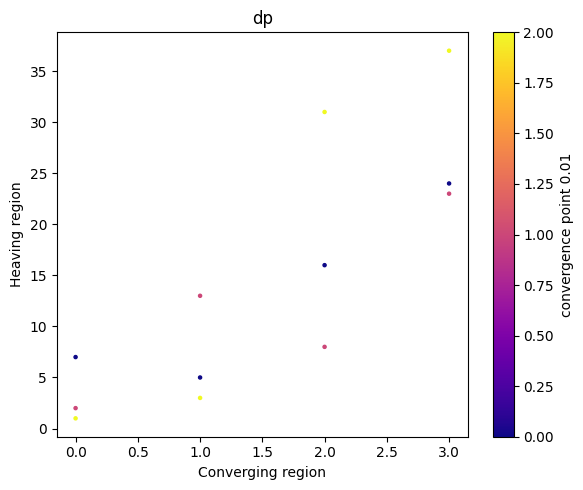

In [35]:
config = all_prob_dicts
error = 0.01

print(config[0][m0][0]["am"])
print(config[0][m0][0]["dp"])
plot_by_heaves_and_regions(config, error, "am")
plot_by_heaves_and_regions(config, error, "dp")